In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from dask.distributed import Client, LocalCluster

client = Client() # Note that `memory_limit` is the limit **per worker**.
# n_workers=4,
#                 threads_per_worker=1,
#                 memory_limit='3GB'
client # If you click the dashboard link in the output, you can monitor real-time progress and get other cool visualizations.

/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52739 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:52739/status,
Dashboard: http://127.0.0.1:52739/status,Workers: 4
Total threads: 16,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52740,Workers: 4
Dashboard: http://127.0.0.1:52739/status,Total threads: 16
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:52754,Total threads: 4
Dashboard: http://127.0.0.1:52757/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:52743,


In [24]:
import copy
import sys
import xarray as xr
import numpy as np
import dask.array as da

import matplotlib
import matplotlib.pyplot as plt
import hvplot.xarray
import scipy.constants

sys.path.append("..")
import processing_dask as pr
import plot_dask
import processing as old_processing

sys.path.append("../../preprocessing/")
from generate_chirp import generate_chirp

In [25]:
matplotlib.rcParams.update({'font.size': 16})

### Open and resave file

In [26]:
# file path to data and configs
#prefix = "/Users/abroome/Documents/SDR/uhd_radar/data/20230710_095333"
#prefix = "/Users/abroome/Desktop/McMurdo2022/11222022_anna/20221122_135614"
#prefix = "/home/radioglaciolgy/anna/uhd_radar/data/20230719_103400"
#prefix = "../../data/20240222_191935"

#prefix = "../../data/20240223_172207" # 40 dB TX gain
#prefix = "../../data/20240223_172330" # 50 dB TX gain

prefix = "/Volumes/T7 Shield/Summit2023/07252023_anna/20230725_161051"

# resave data as zarr for dask processing
zarr_path = pr.save_radar_data_to_zarr(prefix)

# open zarr file, adjust chunk size to be 10 MB - 1 GB based on sample rate/bit depth
raw = xr.open_zarr(zarr_path, chunks={"pulse_idx": 1000})

/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/xarray/core/dataset.py:265: UserWarning: The specified chunks separate the stored chunks along dimension "pulse_idx" starting at index 1000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


### Enter processing parameters

In [27]:
#zero_sample_idx = 36 # X310, fs = 20 MHz
zero_sample_idx = 63 # X310, fs = 50 MHz
#zero_sample_idx = 159 # B205mini, fs = 56 MHz

nstack = 1 # number of pulses to stack

modify_rx_window = False # set to true if you want to window the reference chirp only on receive, false uses ref chirp as transmitted in config file
rx_window = "rectangular" # what you want to change the rx window to if modify_rx_window is true

dielectric_constant = 3.17 # ice (air = 1, 66% velocity coax = 2.2957, ice = 3.17)
sig_speed = scipy.constants.c / np.sqrt(dielectric_constant)

### Generate reference chirp

In [28]:
if modify_rx_window:
    config = copy.deepcopy(raw.config)
    config['GENERATE']['window'] = rx_window
else:
    config = raw.config

chirp_ts, ref_chirp = generate_chirp(config)

### View raw pulse in time domain to check for clipping

In [ ]:
plot1 = np.real(raw.radar_data[:,0]).hvplot.line(x='fast_time') * np.imag(raw.radar_data[:,0]).hvplot.line(x='fast_time')

plot1 = plot1.opts(xlabel='Fast Time (s)', ylabel='Raw Amplitude')
plot1

### Clean and stack data

In [29]:
#stacked = pr.fill_errors(raw, error_fill_value=0.0) # fill receiver errors with 0s

stacked = pr.stack(raw, nstack) # stack 

### Pulse compress data

In [30]:
compressed = pr.pulse_compress(stacked, ref_chirp,
                               fs=stacked.config['GENERATE']['sample_rate'],
                               zero_sample_idx=zero_sample_idx,
                               signal_speed=sig_speed)

compressed_power = xr.apply_ufunc(
    lambda x: 20*np.log10(np.abs(x)),
    compressed,
    dask="parallelized"
)

/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/dask/array/utils.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


### View 1D pulse compressed data

In [ ]:
plot1D = compressed_power.radar_data[0,:].hvplot.line()
plot1D = plot1D * compressed_power.radar_data[-1,:].hvplot.line()
# relevant options: xlim(-80,1000)

plot1D = plot1D.opts(xlabel='Reflection Distance (m)', ylabel='Return Power (dB)')
plot1D

### View 2D pulse compressed data (radargram)

In [ ]:
# USING HOLOVIEWS (sometimes breaks)
plot2D = compressed_power.swap_dims({'pulse_idx': 'slow_time', 'travel_time': 'reflection_distance'}).hvplot.quadmesh(x='slow_time', cmap='inferno', flip_yaxis=True)
# relevant options: ylim=(100,-50), clim=(-90,-40)

plot2D.opts(xlabel='Slow Time (s)', ylabel='Depth (m)', clabel='Return Power (dB)')
plot2D

In [ ]:
# USING MATPLOTLIB (sometimes takes a while)
fig, ax = plt.subplots(1,1, figsize=(10,6), facecolor='white')

p = ax.pcolormesh(compressed_power.slow_time, compressed_power.reflection_distance, compressed_power.radar_data.transpose(), shading='auto', cmap='inferno')
ax.invert_yaxis()
clb = fig.colorbar(p, ax=ax)
clb.set_label('Return Power (dB)')
ax.set_xlabel('Slow Time (s)')
ax.set_ylabel('Distance to Reflector (m)')
# relevant options: ax.set_ylim=(100,-50), ax.set_xlim=(0, 1), vmin=-90, vmax=40


### View spectrogram of stacked data

In [31]:
inpt = raw
inpt["radar_data"].shape

(4000, 987265)

In [34]:
raw

<xarray.Dataset>
Dimensions:     (sample_idx: 4000, pulse_idx: 987265)
Coordinates:
    fast_time   (sample_idx) float64 dask.array<chunksize=(4000,), meta=np.ndarray>
  * pulse_idx   (pulse_idx) int64 0 1 2 3 4 ... 987261 987262 987263 987264
  * sample_idx  (sample_idx) int64 0 1 2 3 4 5 ... 3994 3995 3996 3997 3998 3999
    slow_time   (pulse_idx) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
Data variables:
    radar_data  (sample_idx, pulse_idx) complex64 dask.array<chunksize=(4000, 1000), meta=np.ndarray>
Attributes:
    basename:    20230725_161051
    config:      {'CHIRP': {'num_presums': 1, 'num_pulses': 1000000, 'pulse_r...
    prefix:      /Volumes/T7 Shield/Summit2023/07252023_anna/20230725_161051
    stdout_log:  [1690308235.869] \tReading from config file: ../../config/20...

In [48]:
# data = stacked["radar_data"].to_numpy()
n = 100
normalize = True

pulse = pr.stack(inpt, n)[{'pulse_idx':0}]["radar_data"].to_numpy()

f, t, S = scipy.signal.spectrogram(
    pulse,
    fs=raw.attrs["config"]["GENERATE"]["sample_rate"],
    window='flattop',
    nperseg=128,
    noverlap=64,
    scaling='density', mode='psd',
    return_onesided=False
)

if normalize:
    S /= np.max(S)

/Users/abroome/miniconda3/envs/sprinkles/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


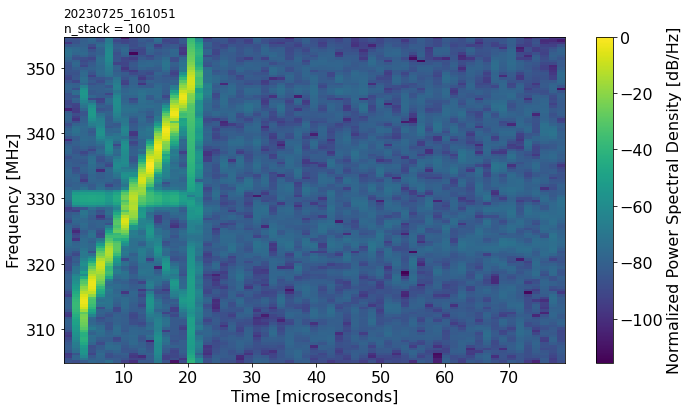

In [49]:
fig, ax = plt.subplots(facecolor='white', figsize=(10,6))
freq_mhz = (np.fft.fftshift(f) + raw.attrs['config']['RF0']['freq']) / 1e6
pcm = ax.pcolormesh(t*1e6, freq_mhz, 10*np.log10(np.abs(np.fft.fftshift(S, axes=0))), shading='nearest') #  vmin=-420, vmax=-200
clb = fig.colorbar(pcm, ax=ax)
if normalize:
    clb.set_label('Normalized Power Spectral Density [dB/Hz]')
else:
    clb.set_label('Power Spectral Density [dB/Hz]')

ax.set_xlabel('Time [microseconds]')
ax.set_ylabel('Frequency [MHz]')
#ax.set_title(f"Spectrogram of received data with n_stack={n}")
ax.text(0, 1.05, prefix.split("/")[-1] + "\n" + f"n_stack = {n}", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontdict={'size': 12})
fig.tight_layout()
plt.show()

In [50]:
fig.savefig(f"outputs/{raw.basename}_ft_spectrogram_n{n}.png", dpi=300)

### View Power Spectrum of All Received Data

In [ ]:
single_stack = pr.stack(raw, raw.radar_data.shape[1])

data_rx_fft = da.fft.fft(raw.radar_data, axis=0) / raw.radar_data.shape[0]
stacked_fft = da.fft.fft(stacked.radar_data, axis=0) / stacked.radar_data.shape[0]
full_fft = da.fft.fft(single_stack.radar_data, axis=0) / single_stack.radar_data.shape[0]

data_rx_fft_pwr = 20*da.log10(da.abs(data_rx_fft))
stacked_fft_pwr = 20*da.log10(da.abs(stacked_fft))
full_fft_pwr = 20*da.log10(da.abs(full_fft))

#data_rx_fft_pwr.shape

In [ ]:
# fig, axs = plt.subplots(2,1)
fig, axs = plt.subplots(facecolor='white', figsize=(10,6))
freqs = np.fft.fftshift(np.fft.fftfreq(data_rx_fft_pwr.shape[0], d=1/raw.config['GENERATE']['sample_rate']))
axs.plot(freqs/1e6, np.fft.fftshift(data_rx_fft_pwr[:,0]), label='Single Pulse')
axs.plot(freqs/1e6, np.fft.fftshift(stacked_fft_pwr[:,0]), label='Single Stack')
axs.plot(freqs/1e6, np.fft.fftshift(full_fft_pwr[:,0]), label='Full File')
axs.set_xlabel('Frequency [MHz]')
axs.set_ylabel('Power [dB]')
axs.set_title('Spectrum -- Power')
axs.grid()
axs.legend()

# axs[1].plot(freqs/1e6, np.fft.fftshift(np.angle(data_rx_fft[:,0])))
# axs[1].plot(freqs/1e6, np.fft.fftshift(np.angle(stacked_fft[:,0])))
# axs[1].plot(freqs/1e6, np.fft.fftshift(np.angle(full_fft[:,0])))
# axs[1].set_xlabel('Frequency [MHz]')
# axs[1].set_ylabel('Phase [rad]')
# axs[1].set_title('Spectrum -- Phase')
# axs[1].grid()
# fig.tight_layout()